<a href="https://colab.research.google.com/github/harperd17/cloud_classification/blob/main/modeling/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook uses existing architectures to train the model from the pretrained weights.

The reason for using pretrained weights is because with the complexity of the models, it would be quite difficult to get to a good level of model performance starting from a random weight selection. The pretrained weights likely pick up on features that are important across many domains, so pretrained weights seem like a good place to start. I will not freeze any of the layers because I have over 5,000 training images, which I think should be sufficient for fine tuning the weights. If I had less data I would freeze all layers except the last layer.

In [ ]:
!git clone https://github.com/harperd17/cloud_classification.git

Cloning into 'cloud_classification'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 238 (delta 75), reused 0 (delta 0), pack-reused 84
Receiving objects: 100% (238/238), 16.31 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
!pip install torchsat
from torchsat.transforms import transforms_seg

     |████████████████████████████████| 46 kB 2.1 MB/s 


In [ ]:
import torch
import torchvision
import glob
from PIL import Image
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 52.2 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bcd7cbd4ada221b4bffa1347acd8a86b33b41b16586d2378ac35519bc2227b58
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=870f251957afec2c047043eb76cd2ecb250ac279fe80c737b60ea52d283b9028
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
drive._mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
from tqdm.autonotebook import tqdm
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, get_accuracy, get_auc

from sklearn.metrics import roc_curve, auc

## Set up the Directory for the Images

In [ ]:
data_dir = '/content/drive/Shareddrives/DavidHarper_Data690_Project/Data/train_images'
#data_dir = '/content/drive/MyDrive/Data690/Project/Data'

## Load the train.csv which holds the file names, classifications, and mask information

In [ ]:
train_data = pd.read_csv(data_dir+'/train.csv')

In [ ]:
# now random sample from the train_data so that I don't have to train these networks on such a large amount of data - the final model should be trained with all the data though
image_names = pd.Series([parts[0] for parts in train_data['Image_Label'].str.split('_')])
sampled = pd.Series(pd.Series(image_names).unique()).sample(3000)
train_data_sampled = train_data[image_names.isin(sampled)]

## Do a Train / Validation Split

In [ ]:
train_valid_images, test_images = train_test_split(sampled,train_size=0.9)
train_images, valid_images = train_test_split(train_valid_images,train_size=0.8)

In [ ]:
test = train_data[image_names.isin(test_images)]
train = train_data[image_names.isin(train_images)]
valid = train_data[image_names.isin(valid_images)]

## Get the GPU Device Configured

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Modeling

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
DEVICE = 'cuda'

model_resnet_imagenet = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS) # this isn't used - it's the same as the normalize_func in the cell below

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
transform_list = [transforms_seg.RandomShift(max_percent=0.15),
                  #transforms_seg.RandomRotation(degrees=15),
                  #transforms_seg.RandomResizedCrop(crop_size=(128,128),target_size=(256,256)),
                  transforms_seg.RandomFlip(),
                  transforms_seg.RandomBrightness()
                  ]

normalize_func = transforms_seg.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#normalize_func = None


output_width=512
output_height=512

test_dataset = CloudData(data_dir, test, output_width=output_width, output_height=output_height, normalize_func = normalize_func)
train_dataset = CloudData(data_dir, train, output_width=output_width, output_height=output_height, normalize_func = normalize_func, transform = transform_list)
valid_dataset = CloudData(data_dir, valid, output_width=output_width, output_height=output_height, normalize_func = normalize_func)

batch_size = 12

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

/content/cloud_classification/helpers/helper_functions.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Label'] = [parts[1] for parts in mask_df['Image_Label'].str.split('_')]
/content/cloud_classification/helpers/helper_functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Image'] = [parts[0] for parts in mask_df['Image_Label'].str.split('_')]


In [ ]:
loss_func = smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(model_resnet_imagenet.parameters())

In [ ]:
results = train_network(model_resnet_imagenet, loss_func, train_loader, epochs=15, device=device, val_loader=valid_loader, optimizer=optimizer, score_funcs={'Accuracy':get_accuracy,'AUC':get_auc})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/180 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
results.to_csv(data_dir+'/train_results.csv')

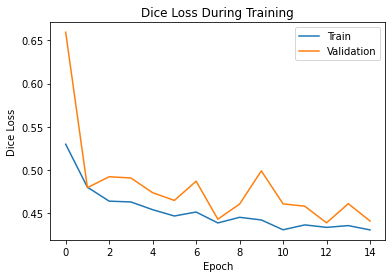

In [ ]:
plt.plot(results['train loss'],label='Train')
plt.plot(results['val loss'],label='Validation')
plt.title('Dice Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend();

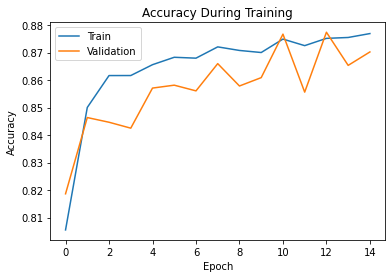

In [ ]:
plt.plot(results['train Accuracy'],label='Train')
plt.plot(results['val Accuracy'],label='Validation')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

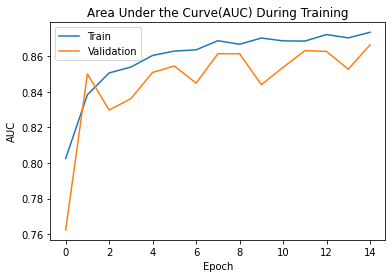

In [ ]:
plt.plot(results['train AUC'],label='Train')
plt.plot(results['val AUC'],label='Validation')
plt.title('Area Under the Curve(AUC) During Training')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend();

In [ ]:
model_resnet_imagenet = model_resnet_imagenet.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


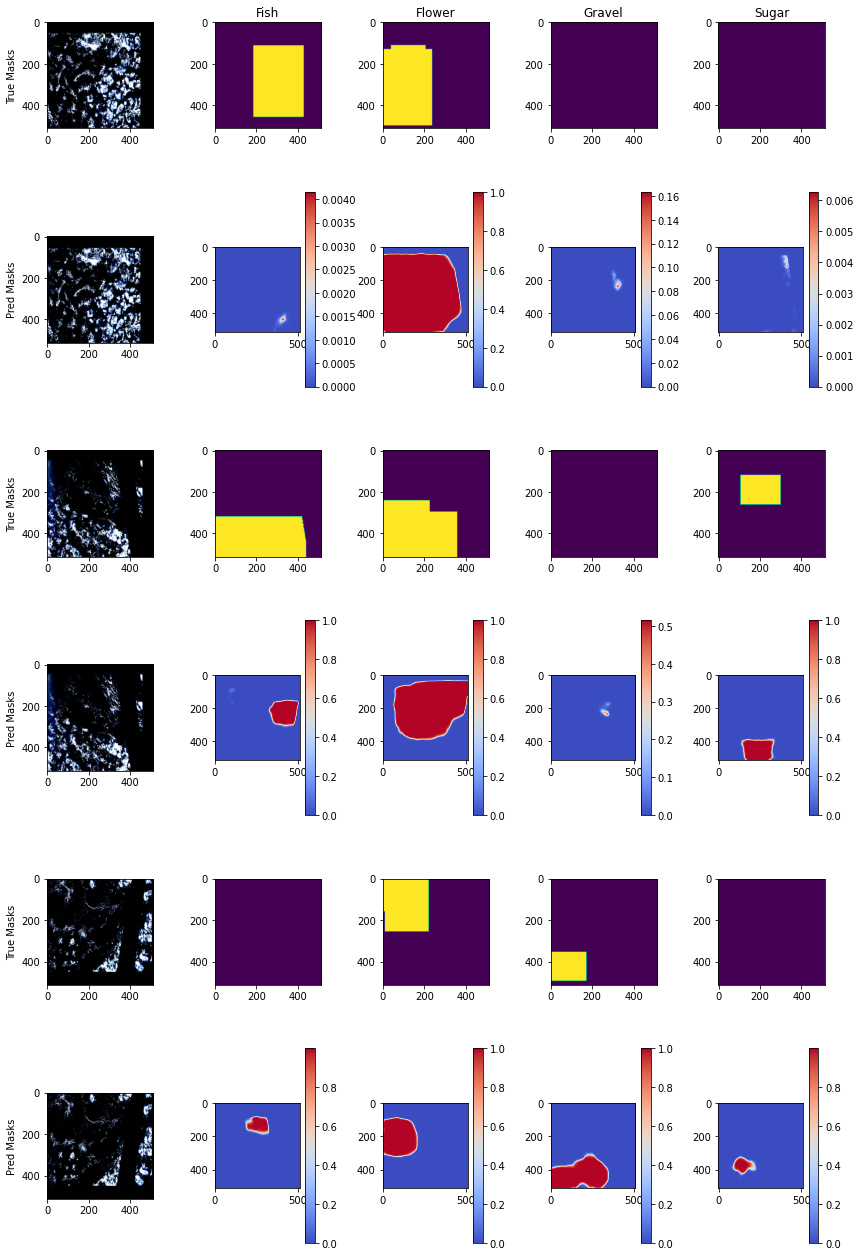

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [model_resnet_imagenet(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


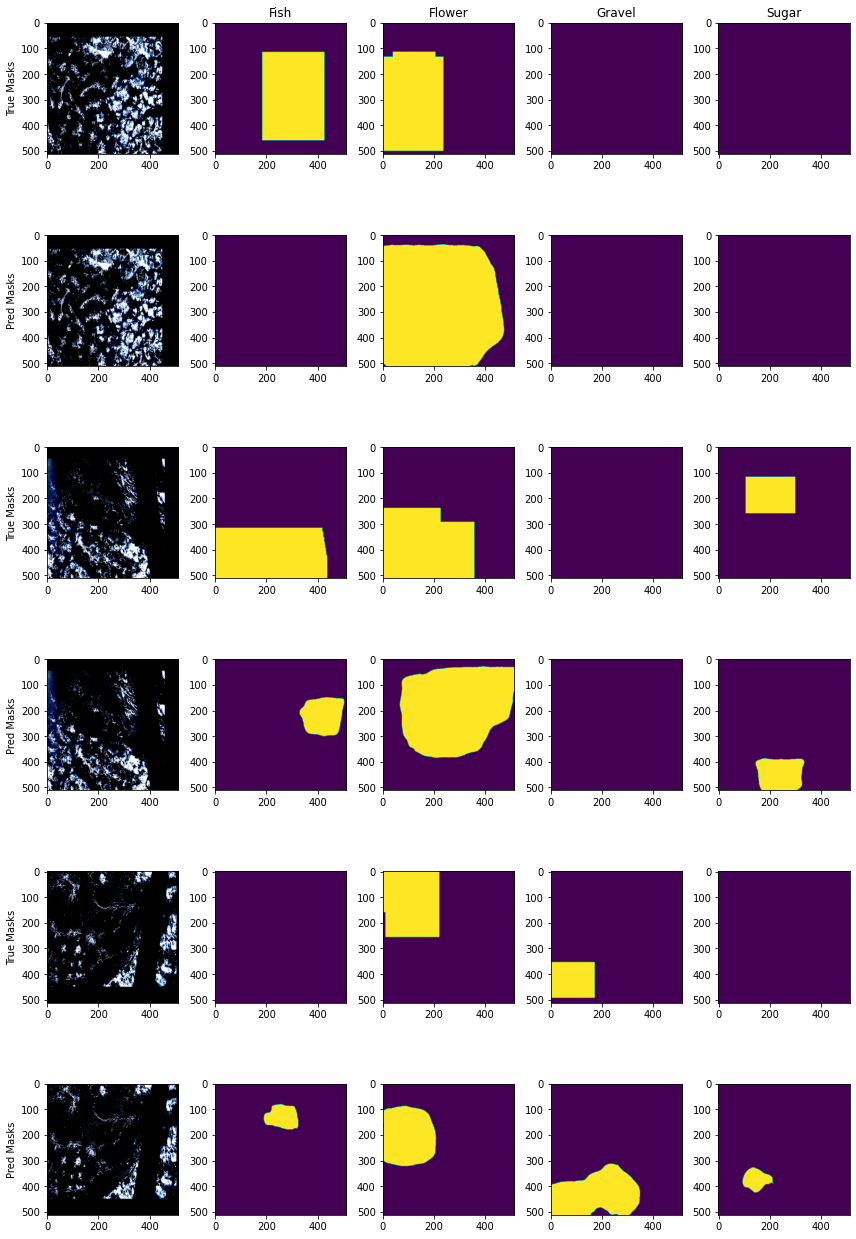

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);

In [ ]:
torch.save({
                'epoch': 15,
                'model_state_dict': model_resnet_imagenet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, data_dir+'/final_model_training_results.pt')